In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
DATA_PATH = os.path.expanduser('~/Documents/datasets/mulan')
DATASETS = ['birds',
            'birds-test',
            'birds-train',
            'CAL500',
            'emotions',
            'emotions-test',
            'emotions-train',
            'mediamill',
            'mediamill-test',
            'mediamill-train',
            'yeast',
            'yeast-test',
            'yeast-train']

In [4]:
NUMBER_OF_GUESSES = 20
N_NEIGHBORS = NUMBER_OF_GUESSES + 12 # 12 being the maximum query size

# Centroid K-NN

Uses the centroid of the query to compute the nearest neighbors

In [5]:
centroidprecisions = {}
centroidrecalls = {}

for ds in DATASETS:
    df = pd.read_csv(os.path.join(DATA_PATH, ds + '_X.csv'))
    queries = pd.read_csv(os.path.join(DATA_PATH, ds + '_query.csv'))
    
    nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS).fit(df)
    centroidprecisions[ds] = []
    centroidrecalls[ds] = []
    
    for row in queries.iterrows():
        query = np.array([int(x) for x in row[1].query.split(',')])
        target = np.array([int(x) for x in row[1].target.split(',')])
        
        examples = df.iloc[query, :]
        centroid = examples.mean()
        distances, indices = nbrs.kneighbors([centroid])
        
        expansion = set(indices[0][~np.isin(indices[0], query, assume_unique=True)][:NUMBER_OF_GUESSES])
        valid_guesses = set(target)

        hits = len(expansion.intersection(valid_guesses))
        size = len(expansion)

        precision = hits / size
        recall = hits / len(target)
        centroidprecisions[ds].append(precision)
        centroidrecalls[ds].append(recall)

In [6]:
centroidprecisions = {key: np.mean(value) for key, value in centroidprecisions.items()}
centroidrecalls = {key: np.mean(value) for key, value in centroidrecalls.items()}

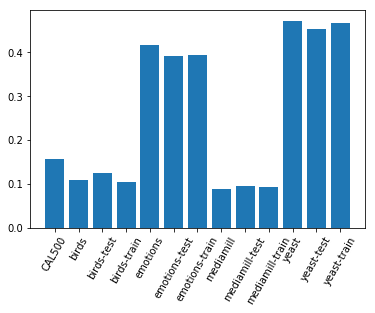

In [7]:
plt.bar(centroidprecisions.keys(), centroidprecisions.values())
plt.xticks(rotation=60);

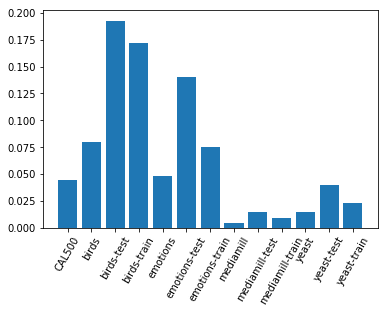

In [8]:
plt.bar(centroidrecalls.keys(), centroidrecalls.values())
plt.xticks(rotation=60);

# Any K-NN

Uses the closest neighbors to any of the query points

In [9]:
def get_closest(distances, indices, remove_duplicate=True):
    distances = distances.flatten()
    indices = indices.flatten()
    inds = distances.argsort()
    closest = indices[inds]
    
    if remove_duplicate:
        _, idx = np.unique(closest, return_index=True)
        return closest[np.sort(idx)]
    return closest

get_closest(np.array([[0, 2, 5],
                      [0, 1, 6],
                      [0, 3, 4]]),
            np.array([[5, 51, 52],
                      [7, 21, 72],
                      [2, 21, 22]]))

array([ 5,  7,  2, 21, 51, 22, 52, 72])

In [10]:
anyprecisions = {}
anyrecalls = {}

for ds in DATASETS:
    df = pd.read_csv(os.path.join(DATA_PATH, ds + '_X.csv'))
    queries = pd.read_csv(os.path.join(DATA_PATH, ds + '_query.csv'))
    
    nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS).fit(df)
    anyprecisions[ds] = []
    anyrecalls[ds] = []
    
    for row in queries.iterrows():
        query = np.array([int(x) for x in row[1].query.split(',')])
        target = np.array([int(x) for x in row[1].target.split(',')])
        
        examples = df.iloc[query, :]
        distances, indices = nbrs.kneighbors(examples)
        ordered = get_closest(distances, indices)
        
        expansion = set(indices[0][~np.isin(indices[0], query, assume_unique=True)][:NUMBER_OF_GUESSES])
        valid_guesses = set(target)

        hits = len(expansion.intersection(valid_guesses))
        size = len(expansion)

        precision = hits / size
        recall = hits / len(target)
        anyprecisions[ds].append(precision)
        anyrecalls[ds].append(recall)
        
        
anyprecisions = {key: np.mean(value) for key, value in anyprecisions.items()}
anyrecalls = {key: np.mean(value) for key, value in anyrecalls.items()}

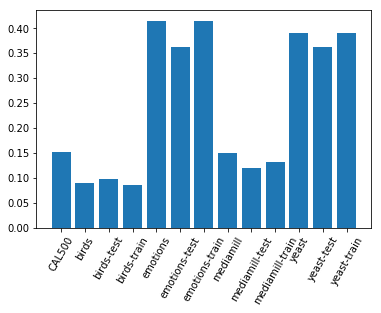

In [11]:
plt.bar(anyprecisions.keys(), anyprecisions.values())
plt.xticks(rotation=60);

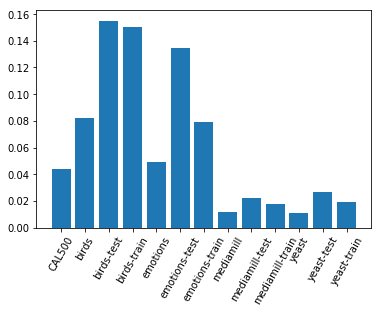

In [12]:
plt.bar(anyrecalls.keys(), anyrecalls.values())
plt.xticks(rotation=60);

In [13]:
resultslist = []
for ds in DATASETS:
    resultslist.append({'dataset': ds, 'precision': centroidprecisions[ds],
                        'recall': centroidrecalls[ds], 'algorithm': 'Centroid KNN'})
    resultslist.append({'dataset': ds, 'precision': anyprecisions[ds],
                        'recall': anyrecalls[ds], 'algorithm': 'Any KNN'})
    
results = pd.DataFrame(resultslist)[['dataset', 'precision', 'recall', 'algorithm']]
results

,dataset,precision,recall,algorithm
0,birds,0.109140,0.080248,Centroid KNN
1,birds,0.090323,0.082391,Any KNN
2,birds-test,0.124468,0.192942,Centroid KNN
3,birds-test,0.097163,0.155144,Any KNN
4,birds-train,0.103916,0.171844,Centroid KNN
5,birds-train,0.084639,0.150097,Any KNN
6,CAL500,0.156336,0.044481,Centroid KNN
7,CAL500,0.151106,0.044107,Any KNN
8,emotions,0.417500,0.047920,Centroid KNN
9,emotions,0.415000,0.049227,Any KNN


In [14]:
with open(os.path.join(DATA_PATH, 'results'), 'a') as f:
    results.to_csv(f, header=False, index=False)